In [1]:
from pyspark.sql import SparkSession

# Spark 세션 생성
spark = SparkSession.builder \
    .appName("HDFS Parquet Read") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .getOrCreate()
# HDFS에서 Parquet 파일 읽기
df = spark.read.parquet("hdfs:///danawa_data/*.parquet")
df.count()
df.show()

25/02/11 15:00:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
                                                                                

+-------+--------+---------------+---------------------------------+----------------------------------+------------------------------+
|scoring|  market|purchasing_date|                     review_title|                    review_content|                          item|
+-------+--------+---------------+---------------------------------+----------------------------------+------------------------------+
|   60점|삼성닷컴|    2024.07.26.|   
S 펜 케이스를 선택하게 된 ...|   S 펜 케이스를 선택하게 된 이...|삼성전자 갤럭시Z 폴드6 S펜 ...|
|  100점|삼성닷컴|    2024.08.05.|     
1. S펜 수납 기능가장 큰 ...|      1. S펜 수납 기능
가장 큰 ...|삼성전자 갤럭시Z 폴드6 S펜 ...|
|   80점|삼성닷컴|    2024.08.26.|
투명하고 가볍고 저렴한 케이스...|투명하고 가볍고 저렴한 케이스를...|삼성전자 갤럭시Z 폴드6 S펜 ...|
|   80점|삼성닷컴|    2024.08.02.|    
노트20 기종만 4년 여 사용...|    노트20 기종만 4년 여 사용한...|삼성전자 갤럭시Z 폴드6 S펜 ...|
|  100점|삼성닷컴|    2024.07.24.| 
노트 사용하다가 이번에 폴드6...|  노트 사용하다가 이번에 폴드6 ...|삼성전자 갤럭시Z 폴드6 S펜 ...|
|   80점|삼성닷컴|    2024.07.30.|  
사전구매 했을 때 폴드6보다 ...|  사전구매 했을 때 폴드6보다 일...|삼성전자 갤럭시Z 폴드6 S펜 ...|
|  10

## 리뷰 형태 탐색

In [3]:
# 스키마 확인
df.printSchema()

# 기본 통계 정보 확인
df.describe().show()


root
 |-- scoring: string (nullable = true)
 |-- market: string (nullable = true)
 |-- purchasing_date: string (nullable = true)
 |-- review_title: string (nullable = true)
 |-- review_content: string (nullable = true)
 |-- item: string (nullable = true)



[Stage 8:============================================>              (3 + 1) / 4]

+-------+-------+--------+---------------+------------------------------------+---------------------------------+-------------------------------+
|summary|scoring|  market|purchasing_date|                        review_title|                   review_content|                           item|
+-------+-------+--------+---------------+------------------------------------+---------------------------------+-------------------------------+
|  count|  13093|   13093|          13093|                               13093|                            13093|                          13093|
|   mean|   null|    null|           null|                                24.0|                             null|                           null|
| stddev|   null|    null|           null|                                null|                             null|                           null|
|    min|  100점|  11번가|    2023.11.22.|         
 s pen 넣는 부분이 케이...|     



별점. 0점은  없는건가...|        APPLE 아이폰16 128GB...|

In [6]:
# 각 컬럼의 고유값 개수 확인
for col in df.columns:
    print(f"{col}: {df.select(col).distinct().count()} unique values")

scoring: 5 unique values
market: 19 unique values
purchasing_date: 384 unique values
review_title: 6547 unique values
review_content: 10217 unique values
item: 35 unique values


In [9]:
# 결측치 확인
from pyspark.sql.functions import col, isnan, when, count

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# 이상값 확인
df.select("scoring").summary("min", "25%", "50%", "75%", "max").show()


+-------+------+---------------+------------+--------------+----+
|scoring|market|purchasing_date|review_title|review_content|item|
+-------+------+---------------+------------+--------------+----+
|      0|     0|              0|           0|             0|   0|
+-------+------+---------------+------------+--------------+----+

+-------+-------+
|summary|scoring|
+-------+-------+
|    min|  100점|
|    25%|   null|
|    50%|   null|
|    75%|   null|
|    max|   80점|
+-------+-------+



In [11]:
# 리뷰 내용 확인

from pyspark.sql.functions import length, avg

# 리뷰 길이 통계
df.select(avg(length("review_content")).alias("avg_review_length")).show()

# 가장 긴 리뷰와 가장 짧은 리뷰 확인
df.orderBy(length("review_content").desc()).select("review_content").show(1, truncate=False)
df.orderBy(length("review_content").asc()).select("review_content").show(1, truncate=False)


+-----------------+
|avg_review_length|
+-----------------+
|56.10585809211029|
+-----------------+

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
# 시간 기반 분석
from pyspark.sql.functions import to_date, year, month

# 날짜별 리뷰 수 확인
df.groupBy(to_date("purchasing_date").alias("date")).count().orderBy("date").show()

# 월별 리뷰 수 확인
df.groupBy(year("purchasing_date"), month("purchasing_date")).count().orderBy("year(purchasing_date)", "month(purchasing_date)").show()


+----+-----+
|date|count|
+----+-----+
|null|13093|
+----+-----+

+---------------------+----------------------+-----+
|year(purchasing_date)|month(purchasing_date)|count|
+---------------------+----------------------+-----+
|                 null|                  null|13093|
+---------------------+----------------------+-----+



In [16]:
# 시각화를 위한 데이터 샘플링 및 Pandas DataFrame으로 변환
pandas_df = df.sample(fraction=0.1, seed=42).toPandas()


/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48624 (\N{HANGUL SYLLABLE BYU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABL

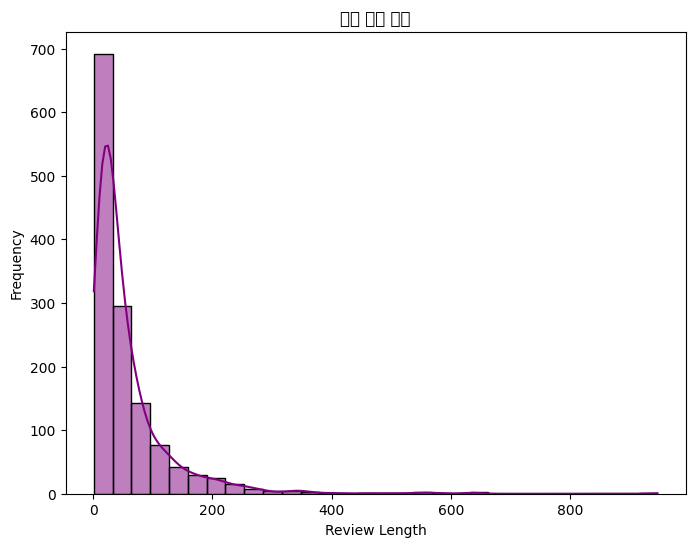

In [23]:
# 리뷰 길이 시각화
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns

# 리뷰 길이 계산
pandas_df['review_length'] = pandas_df['review_content'].apply(len)

# 히스토그램으로 리뷰 길이 분포 시각화
plt.figure(figsize=(8, 6))
sns.histplot(pandas_df['review_length'], kde=True, color='purple', bins=30)
plt.title('리뷰 길이 분포')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()



/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL S

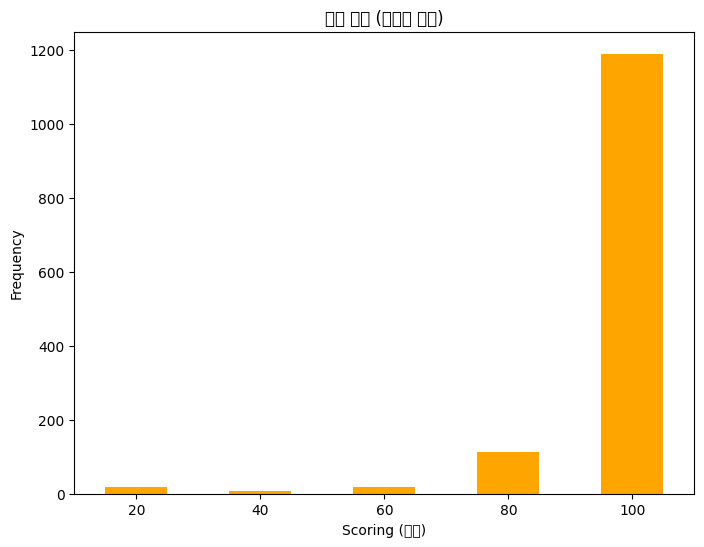

In [24]:
# 평점 분포 확인

# 'scoring' 데이터를 숫자로 변환
pandas_df['scoring_numeric'] = pandas_df['scoring'].str.replace('점', '').astype(int)

# 점수별 빈도수 계산 및 정렬
scoring_counts = pandas_df['scoring_numeric'].value_counts().sort_index()

# 막대그래프 시각화
plt.figure(figsize=(8, 6))
scoring_counts.plot(kind='bar', color='orange')
plt.title('평점 분포 (정렬된 점수)')
plt.xlabel('Scoring (점수)')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


## 리뷰 내용 탐색

In [25]:
import re
from collections import Counter

# 리뷰 텍스트 데이터 정리 (전처리)
def preprocess_text(text):
    # 소문자로 변환, 특수문자 제거, 숫자 제거
    text = re.sub(r'[^\w\s]', '', text.lower())  # 특수문자 제거
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    return text

# 리뷰 텍스트에 전처리 적용
pandas_df['cleaned_review'] = pandas_df['review_content'].apply(preprocess_text)


In [26]:
# 단어 빈도 계산

# 모든 리뷰의 단어를 하나의 리스트로 합치기
all_words = pandas_df['cleaned_review'].str.split().sum()

# 단어 빈도 계산
word_counts = Counter(all_words)

# 상위 10개 단어 출력
most_common_words = word_counts.most_common(10)
print("가장 많이 등장한 단어:")
for word, count in most_common_words:
    print(f"{word}: {count}")


가장 많이 등장한 단어:
잘: 255
너무: 212
좋아요: 190
빠르고: 121
배송: 110
만족합니다: 96
배송도: 95
좋습니다: 92
감사합니다: 87
더: 82


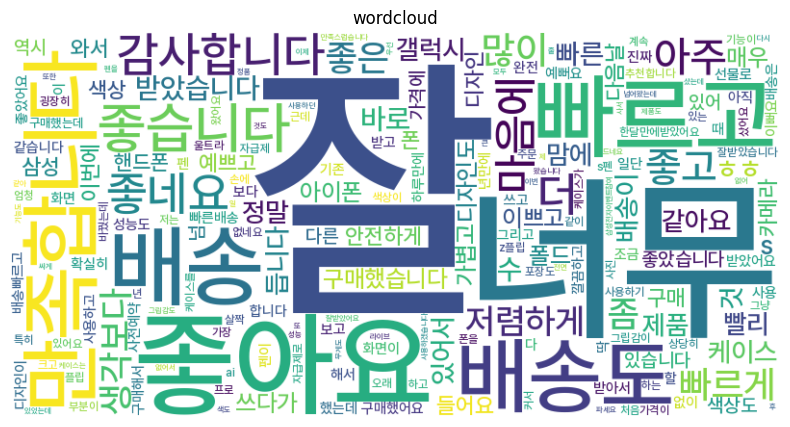

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 경로 (OS에 따라 다름)
font_path = 'font/Pretendard-Medium.ttf'  

# 워드클라우드 생성
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('wordcloud')
plt.show()
